# Final Project - camera calibration and undistortion

In [21]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

In [22]:
def onlyOneChessboard(grayImage,type,n):
    """
    Args:
    grayImage (ndarray): grayscale of current image, 
    type (int): number indicating type if checkerboard
    n (int): number indicating number of checkerboard of current type

    Returns:
        image: the checkerboard to look at
    """    
    
    address = 'templates/' + str(type) + '_board_' + str(n) + '.png'
    template = cv2.imread(address)
    template = template[...,0]
    res = cv2.matchTemplate(grayImage, template, cv2.TM_CCORR_NORMED)

    _, _, _, maxLoc = cv2.minMaxLoc(res)
    topLeft = maxLoc
    bottomRight = (topLeft[0] + template.shape[1], topLeft[1] + template.shape[0])
    
    oneChessboard = grayImage
    oneChessboard[0:topLeft[1],...] = 125
    oneChessboard[...,0:topLeft[0]] = 125
    oneChessboard[bottomRight[1]:grayImage.shape[0],...] = 125
    oneChessboard[...,bottomRight[0]:grayImage.shape[1]] = 125
    
    return oneChessboard

In [23]:
def calculateError(objpoints, imgpoints, rvecs, tvecs, camMatrix, dist):
    """Function to calculate the error of the camera calibration
    Args:
        objpoints (ndarray): the 3D points of the chessboard corners
        imgpoints (ndarray): the 2D points of the chessboard corners
        rvecs (ndarray): rotation vectors
        tvecs (ndarray): translation vectors 
        camMatrix (ndarray): camera matrix 
        dist (ndarray): distortion coefficients 
    """    
    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], camMatrix, dist)
        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
        mean_error += error
    print( "Total error: {}".format(mean_error/len(objpoints)))
    return mean_error/len(objpoints)

In [24]:
def findMultipleChessCorners(nb_horizontal, nb_vertical, nb_board, type, leftImg, rightImg, objpoints, 
                             leftImgPoints, rightImgPoints, time=0, squareSize=100):
    """Function finding chessboard corners of multiple checkerboards
    Args:
        nb_horizontal (int): number of horizontal corners
        nb_vertical (int): number of vertical corners
        nb_board (int): board type number
        type (int): board type
        leftImg (ndarray): left image
        rightImg (ndarray): right image
        objpoints (list): list of object points
        leftImgPoints (list): list of left image points
        rightImgPoints (list): list of right image points
        time (int, optional): time to display the found corners. Defaults to 0.
        squareSize (int, optional): size of the checkerboard squares (in mm). Defaults to 100.

    Returns:
        objpoints, leftImgPoints, rightImgPoints (list, list, list): 
                            list of object points and two lists of image points 
    """    
    leftWithCorners = leftImg
    rightWithCornes = rightImg
    leftGray = cv2.cvtColor(leftImg, cv2.COLOR_BGR2GRAY)
    rightGray = cv2.cvtColor(rightImg, cv2.COLOR_BGR2GRAY)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    for i in range(1,nb_board):
        objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32)
        objp[:,:2] = np.mgrid[0:nb_horizontal,0:nb_vertical].T.reshape(-1,2)
        objp = objp * squareSize        # Coordinates of the squares in the real world (mm)
        # Apply a template to look only at one specific chessboard
        currentLeftGray = onlyOneChessboard(leftGray,type,i)
        currentRightGray = onlyOneChessboard(rightGray,type,i)
        leftGray = cv2.cvtColor(leftImg, cv2.COLOR_BGR2GRAY)
        rightGray = cv2.cvtColor(rightImg, cv2.COLOR_BGR2GRAY)

        leftRet, leftCorners = cv2.findChessboardCornersSB(currentLeftGray, (nb_horizontal,nb_vertical),
                                                         flags=cv2.CALIB_CB_EXHAUSTIVE)
        rightRet, rightCorners = cv2.findChessboardCornersSB(currentRightGray, (nb_horizontal,nb_vertical),
                                                            flags=cv2.CALIB_CB_EXHAUSTIVE)

        # If found in both frames, add object points + image points (after refining them)
        if leftRet and rightRet:
            objpoints.append(objp)
            leftCorners = cv2.cornerSubPix(currentLeftGray,leftCorners,(5,5),(-1,-1),criteria)
            rightCorners = cv2.cornerSubPix(currentRightGray,rightCorners,(5,5),(-1,-1),criteria)
            leftImgPoints.append(leftCorners)
            rightImgPoints.append(rightCorners)

            # Draw and display the corners if wanted
            if time != 0:
                leftWithCorners = cv2.drawChessboardCorners(leftWithCorners, (nb_horizontal,nb_vertical), 
                                                            leftCorners,leftRet)
                rightWithCornes = cv2.drawChessboardCorners(rightWithCornes, (nb_horizontal,nb_vertical), 
                                                            rightCorners,rightRet)
                # Show both images, left on top of right
                both = np.concatenate((leftWithCorners, rightWithCornes), axis=0)
                cv2.imshow('Corners', both)
                cv2.waitKey(time)
    
    return objpoints, leftImgPoints, rightImgPoints

In [55]:
def findAllChessCorners(leftImgs, rightImgs, time=0):
    """Function looping through all the left and right images and finding the 
    corners of all the checkerboards

    Args:
        leftImgs (glob): glob pointing to the left images
        rightImgs (glob): glob pointing to the right images
        time (int, optional): time to display the found corners. Defaults to 0.

    Returns:
        objpoints (list): list of all the object points
        leftImgPoints (list): list of all the left image points
        rightImgPoints (list): list of all the right image points
    """    
    objpoints = [] # 3d point in real world space
    leftImgPoints = [] 
    rightImgPoints = [] # 2d points in image plane.
    
    for fname1, fname2 in zip(leftImgs, rightImgs):
        leftImg = cv2.imread(fname1)
        rightImg = cv2.imread(fname2)
        
        # Find the chess board corners for the boards with shape (7,5)
        nb_horizontal = 7
        nb_vertical = 5
        
        findMultipleChessCorners(nb_horizontal, nb_vertical, 
                                     6, 1, leftImg, rightImg, objpoints, 
                                     leftImgPoints, rightImgPoints, time)

        # Find the chess board corners for the boards with shape (5,7)
        nb_horizontal = 5
        nb_vertical = 7
        
        findMultipleChessCorners(nb_horizontal, nb_vertical, 
                                     6, 2, leftImg, rightImg, objpoints, 
                                     leftImgPoints, rightImgPoints, time)
        # Find the chess board corners for the boards with shape (11,7)
        nb_horizontal = 11
        nb_vertical = 7
        
        findMultipleChessCorners(nb_horizontal, nb_vertical, 
                                     3, 3, leftImg, rightImg, objpoints, 
                                     leftImgPoints, rightImgPoints, time)
        # Find the chess board corners for the board with shape (5,15)
        nb_horizontal = 5
        nb_vertical = 15
        
        findMultipleChessCorners(nb_horizontal, nb_vertical,
                                     2, 4, leftImg, rightImg, objpoints, 
                                     leftImgPoints, rightImgPoints, time)
    if time != 0:
        cv2.destroyAllWindows()
    return objpoints, leftImgPoints, rightImgPoints

In [26]:
def undistortAll(images, cameraMatrix, dist, newCameraMatrix, roi, side):
    """
    Function to undistort and crop all images in a folder and save them in a 
    new "undistorted/" folder
    Args:
    images (glob): glob pointing to the images to undistort
    cameraMatrix (ndarray): the camera matrix
    dist (ndarray): distortion coefficients
    newCameraMatrix (ndarray): new refined camera matrix 
    """    
    for fname in images:
        img = cv2.imread(fname)
        undistorted = cv2.undistort(img, cameraMatrix, dist, None, newCameraMatrix)
        x,y,w,h = roi
        undistorted = undistorted[y:y+h, x:x+w]
        cv2.imwrite("final_project_data/undistorted/" + side + "/" + fname.split("/")[-1], undistorted)

In [56]:
# Load the left and right images
leftImgs = glob.glob("final_project_data/calib/image_02/data/*.png", recursive=True)
rightImgs = glob.glob("final_project_data/calib/image_03/data/*.png", recursive=True)

In [57]:
#NOTE: this takes ~1 min to run with time=100 (0.1 sec per checkerboard in image)
# Obtain the left and right image points, as well as all the object points
objpoints, leftImgPoints, rightImgPoints = findAllChessCorners(leftImgs, rightImgs, time=10)

In [62]:
#NOTE: this takes a while to run (~2.5 minutes)
# Getting left camera matrix and distortion coefficients
leftGray = cv2.imread('final_project_data/calib/image_02/data/0000000000.png', cv2.IMREAD_GRAYSCALE)
h, w = leftGray.shape[:2]
ret, leftCamMatrix, leftCamDist, leftRvecs, leftTvecs = cv2.calibrateCamera(objpoints, leftImgPoints, leftGray.shape[::-1],None,None)
newLeftCamMatrix, leftRoi = cv2.getOptimalNewCameraMatrix(leftCamMatrix,leftCamDist,(w,h),1,(w,h))

In [63]:
#NOTE: this takes a while to run (~2.5 minutes)
# Getting right camera matrix
rightGray = cv2.imread('final_project_data/calib/image_03/data/0000000000.png', cv2.IMREAD_GRAYSCALE)
h, w = rightGray.shape[:2]
ret, rightCamMatrix, rightCamDist, rightRvecs, rightTvecs = cv2.calibrateCamera(objpoints, rightImgPoints, rightGray.shape[::-1], None, None)
newRightCamMatrix, rightRoi = cv2.getOptimalNewCameraMatrix(rightCamMatrix,rightCamDist,(w,h),1,(w,h))

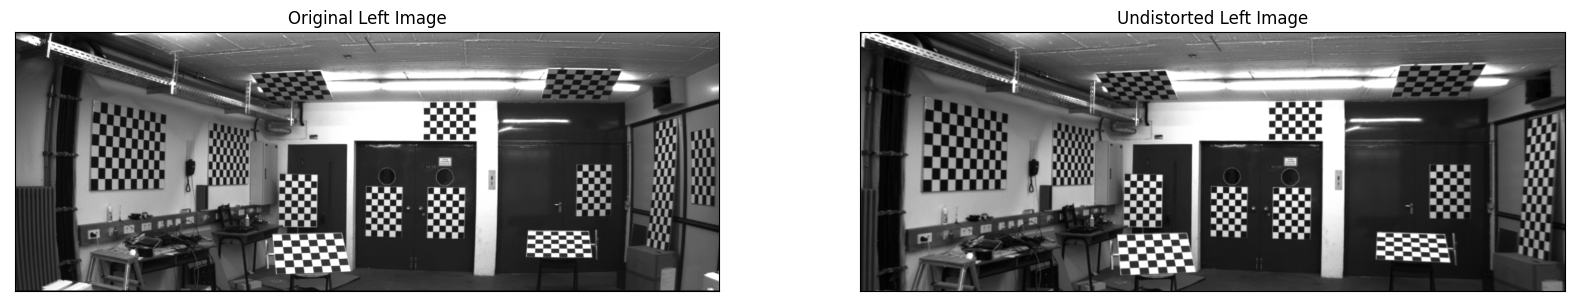

In [65]:
leftMonoDist = cv2.undistort(leftGray, leftCamMatrix, leftCamDist, newLeftCamMatrix)

# Plot the original left photo next to the undistorted left photo
plt.figure(figsize=(20,20))
plt.subplot(121),plt.imshow(leftGray,cmap = 'gray')
plt.title('Original Left Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(leftMonoDist,cmap = 'gray')
plt.title('Undistorted Left Image'), plt.xticks([]), plt.yticks([])
plt.show()

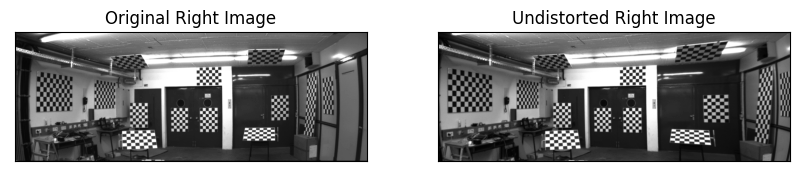

In [61]:
rightMonoDist = cv2.undistort(rightGray, rightCamMatrix, rightCamDist, newRightCamMatrix)

# Plot the original right photo next to the undistorted right photo
plt.figure(figsize=(10,10))
plt.subplot(121),plt.imshow(rightGray,cmap = 'gray')
plt.title('Original Right Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(rightMonoDist,cmap = 'gray')
plt.title('Undistorted Right Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [33]:
# Calculate the error for the single camera calibrations
calculateError(objpoints, leftImgPoints, leftRvecs, leftTvecs, leftCamMatrix, leftCamDist)

Total error: 8.212271479867075


8.212271479867075

In [34]:
calculateError(objpoints, rightImgPoints, rightRvecs, rightTvecs, rightCamMatrix, rightCamDist)

Total error: 9.110255024837748


9.110255024837748

In [35]:
#NOTE: this takes about a minute to run
# Stereo calibrate the cameras using the two optimal camera matrices from above
# By passing the flag CALIB_FIX_INTRINSIC, we are telling the function to use the
# optimal camera matrices we calculated above, instead of recalculating them here
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001) # termination criteria

ret, leftCamMatrix, leftCamDist, rightCamMatrix, rightCamDist, Rot, Trans, Emat, Fmat = \
        cv2.stereoCalibrate(objpoints, leftImgPoints, rightImgPoints, leftCamMatrix, 
                            leftCamDist, rightCamMatrix, rightCamDist, leftGray.shape[::-1], 
                            criteria, flags = cv2.CALIB_FIX_INTRINSIC)

### Source: https://learnopencv.com/making-a-low-cost-stereo-camera-using-opencv/#stereo-rectification

In [36]:
# Stereo rectify the images to have them be in the same plane
rectifiedLeft, rectifiedRight, projectionLeft, projectionRight, Q, roiLeft, roiRight=\
    cv2.stereoRectify(leftCamMatrix, leftCamDist, rightCamMatrix, rightCamDist,
                      leftGray.shape[::-1], Rot, Trans)

In [37]:
# Calculate the mappings that transform the stereo image pair to undistorted
# rectified stereo image pairs 
leftStereoMapX, leftStereoMapY = cv2.initUndistortRectifyMap(leftCamMatrix, leftCamDist, 
                                                             rectifiedLeft, projectionLeft, 
                                                             leftGray.shape[::-1], cv2.CV_16SC2)
rightStereoMapX, rightStereoMapY = cv2.initUndistortRectifyMap(rightCamMatrix, rightCamDist,
                                                                rectifiedRight, projectionRight, 
                                                                rightGray.shape[::-1], cv2.CV_16SC2)

In [17]:
# Save the parameters to an xml file 
cv_file = cv2.FileStorage("stereoCamParameters.xml", cv2.FILE_STORAGE_WRITE)
cv_file.write("Left_Stereo_Map_x",leftStereoMapX)
cv_file.write("Left_Stereo_Map_y",leftStereoMapY)
cv_file.write("Right_Stereo_Map_x",rightStereoMapX)
cv_file.write("Right_Stereo_Map_y",rightStereoMapY)
cv_file.release()

# From here, undistortion and remapping should happen
ref: https://learnopencv.com/depth-perception-using-stereo-camera-python-c/ 

To avoid running the above code again, simply fetch the saved stereo maps from the file!


Difference between calibrating each camera individually vs stereo calibration; https://stackoverflow.com/questions/71699988/difference-between-stereo-camera-calibration-vs-two-single-camera-calibrations-u 

TL;DR - single camera gives intrinsics only, whilst cv2.stereoCalibrate gives extrinsics as well, for depth estimation etc

**NOTE:** can the two functions below be replaced by simply cv2.undiort() like above?
ref: https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html#:~:text=1.%20Using%20cv.undistort()

In [18]:
# Fetch the saved parameters from earlier (if you don't want to run the above code which takes ages)
cvFile = cv2.FileStorage("stereoCamParameters.xml", cv2.FILE_STORAGE_READ)
leftStereoMapX = cvFile.getNode("Left_Stereo_Map_x").mat()
leftStereoMapY = cvFile.getNode("Left_Stereo_Map_y").mat()
rightStereoMapX = cvFile.getNode("Right_Stereo_Map_x").mat()
rightStereoMapY = cvFile.getNode("Right_Stereo_Map_y").mat()
cvFile.release()

In [19]:
def stereoUndistortAll(leftImgs, rightImgs, leftMapX, leftMapY, rightMapX, rightMapY):
    """
    Function to undistort stereo pair of images using the obtained stereo maps.
    The undistorted images are saved in a new "stereo_undistorted/" folder
    Args:
    leftImgs (glob): glob pointing to the left images
    rightImgs (glob): glob pointing to the right images
    leftMapX (ndarray): left stereo map x
    leftMapY (ndarray): left stereo map y
    rightMapX (ndarray): right stereo map x
    rightMapY (ndarray): right stereo map y
    """    
    for fname1, fname2 in zip(leftImgs, rightImgs):
        leftImg = cv2.imread(fname1)
        rightImg = cv2.imread(fname2)
        # Display the two images before rectification
        cv2.imshow("Left before rectification", leftImg)
        cv2.imshow("Right before rectification", rightImg)
        rectifiedL = cv2.remap(leftImg, leftMapX, leftMapY, cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)
        rectifiedR = cv2.remap(rightImg, rightMapX, rightMapY, cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)
        # Display the two images after rectification
        cv2.imshow("Left after rectification", rectifiedL)
        cv2.imshow("Right after rectification", rectifiedR)
        cv2.waitKey(0)
        combined = rectifiedR.copy()
        combined[:,:,0] = rectifiedR[:,:,0]
        combined[:,:,1] = rectifiedR[:,:,1]
        combined[:,:,2] = rectifiedL[:,:,2]
        cv2.imshow("Output image", combined)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        return
        cv2.imwrite("final_project_data/stereo_undistorted/left/" + fname1.split("/")[-1], rectifiedL)        
        cv2.imwrite("final_project_data/stereo_undistorted/right/" + fname2.split("/")[-1], rectifiedR)

In [20]:
stereoUndistortAll(leftImgs, rightImgs, leftStereoMapX, leftStereoMapY, rightStereoMapX, rightStereoMapY)

In [45]:
# Create a stereoBM object and tweak the parameters to obtain the best disparity map

def nothing(x):
    pass
def blockMatchImagePair(leftImg, rightImg, leftMapX, leftMapY, rightMapX, rightMapY):
    cv2.namedWindow('disp',cv2.WINDOW_NORMAL)
    cv2.resizeWindow('disp',800,800)
    
    cv2.createTrackbar('minDisparity','disp',5,25,nothing)
    cv2.createTrackbar('numDisparities','disp',1,17,nothing)
    cv2.createTrackbar('blockSize','disp',5,50,nothing)
    cv2.createTrackbar('textureThreshold','disp',10,100,nothing)
    cv2.createTrackbar('disp12MaxDiff','disp',5,25,nothing)
    cv2.createTrackbar('uniquenessRatio','disp',15,100,nothing)
    cv2.createTrackbar('speckleRange','disp',0,100,nothing)
    cv2.createTrackbar('speckleWindowSize','disp',3,25,nothing)
    
    # Creating an object of StereoBM algorithm
    stereo = cv2.StereoBM_create()
    

    img_left = leftImg.copy()
    img_right = rightImg.copy()

    # convert images to grayscale for template matching
    imgL_gray = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    imgR_gray = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    rectifiedL = cv2.remap(imgL_gray, leftMapX, leftMapY, cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)
    rectifiedR = cv2.remap(imgR_gray, rightMapX, rightMapY, cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)
    while True:
        
        # Updating the parameters based on the trackbar positions
        numDisparities = cv2.getTrackbarPos('numDisparities','disp')*16
        numDisparities = 16 if numDisparities == 0 else numDisparities
        blockSize = cv2.getTrackbarPos('blockSize','disp')
        if blockSize % 2 == 0:
            blockSize += 1

        if blockSize < 5:
            blockSize = 5


        textureThreshold = cv2.getTrackbarPos('textureThreshold','disp')
        uniquenessRatio = cv2.getTrackbarPos('uniquenessRatio','disp')
        speckleRange = cv2.getTrackbarPos('speckleRange','disp')
        speckleWindowSize = cv2.getTrackbarPos('speckleWindowSize','disp')
        disp12MaxDiff = cv2.getTrackbarPos('disp12MaxDiff','disp')
        minDisparity = cv2.getTrackbarPos('minDisparity','disp')
            
        # Setting the updated parameters before computing disparity map
        stereo.setNumDisparities(numDisparities)
        stereo.setBlockSize(blockSize)
        stereo.setTextureThreshold(textureThreshold)
        stereo.setUniquenessRatio(uniquenessRatio)
        stereo.setSpeckleRange(speckleRange)
        stereo.setSpeckleWindowSize(speckleWindowSize)
        stereo.setDisp12MaxDiff(disp12MaxDiff)
        stereo.setMinDisparity(minDisparity)

        # Calculating disparity using the StereoBM algorithm
        disparity =  stereo.compute(rectifiedL, rectifiedR).astype(np.float32)
        # NOTE: Code returns a 16bit signed single channel image,
        # CV_16S containing a disparity map scaled by 16. Hence it 
        # is essential to convert it to CV_32F and scale it down 16 times.


        # Scaling down the disparity values and normalizing them 
        disparity = (disparity/16.0 - minDisparity)/numDisparities

        # Displaying the disparity map as well as the two rectified images
        cv2.imshow("Left", rectifiedL)
        cv2.imshow("Right", rectifiedR)
        cv2.imshow("disp",disparity)
    
        # Close window using esc key
        if cv2.waitKey(1) == 27:
            break 
    cv2.destroyAllWindows()

In [47]:
leftImg = cv2.imread(leftImgs[10])
rightImg = cv2.imread(rightImgs[10])
blockMatchImagePair(leftImg, rightImg, leftStereoMapX, leftStereoMapY, rightStereoMapX, rightStereoMapY)

# TO DO
Verify the results! 